# Nobel Twin Familial Cirrhosis Serum Machine Learning Metadata Analysis
Throughout the ML analyses for the serum and fecal data, I added metadata features (BMI, Age, Gender) to improve the performance of the model. For the multi-omic and fecal models, the addition of these features typically led to an improvment. For the serum models, adding these metadata features actually led to a drop in performance. To better understand which metadata feature could be causing this, I'll be using the best performing serum RF model (Selected features, 49 total) and seeing which metadata features lead to in increase or drop off in performance.

**Author: Tobin Groth (tgroth@ucsd.edu)**

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import qiime2
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate
from sklearn import metrics
from sklearn.utils import shuffle
import numpy as np
import pylab as pl
import qiime2
import os


os.chdir('/Users/tgroth/Google Drive/knight_twin_NAFLD/serum_analysis')

# Loading in Necessary Metadata and Feature Tables

In [6]:
# loading in metadata
meta = pd.read_csv('../metadata-matched.tsv',sep='\t',index_col=0)
meta.head(3)

,ATTRIBUTE_AgeInYears,ATTRIBUTE_BarcodeSequence,ATTRIBUTE_BiologicalSex,ATTRIBUTE_ChromatographyAndPhase,ATTRIBUTE_ComorbidityListDOIDIndex,ATTRIBUTE_Country,ATTRIBUTE_DOIDCommonName,ATTRIBUTE_DOIDOntologyIndex,ATTRIBUTE_DepthorAltitudeMeters,ATTRIBUTE_Description,...,ATTRIBUTE_waist_circumference_cm,ATTRIBUTE_water_lot,ATTRIBUTE_wbc,ATTRIBUTE_weight,ATTRIBUTE_weight_units,ATTRIBUTE_well_description,ATTRIBUTE_well_id,ATTRIBUTE_zygocity,ATTRIBUTE_zygoticity,filename
sampleid,,,,,,,,,,,,,,,,,,,,,
TW-CO-002,54,TCATGGCCTCCG,male,not applicable,not applicable,United States of America,not applicable,not applicable,200,loomba_nobel_liver,...,98,RNBF9925,8,80.6,kg,Loomba_Twin_Plate_2_TW.CO.002_E2,E2,2,2.0,TW-CO-002_RC4_01_35874.mzXML
TW-BT-001,49,CACACAAAGTCA,female,not applicable,not applicable,United States of America,not applicable,not applicable,200,loomba_nobel_liver,...,92,RNBF9925,8.5,80.8,kg,Loomba_Twin_Plate_2_TW.BT.001_E10,E10,1,1.0,TW-BT-001_RH12_01_35942.mzXML
TW-CA-002,61,TCCGGCGGGCAA,male,not applicable,not applicable,United States of America,not applicable,not applicable,200,loomba_nobel_liver,...,115,RNBF9925,6.2,99.7,kg,Loomba_Twin_Plate_2_TW.CA.002_B10,B10,1,1.0,TW-CA-002_RH6_01_35936.mzXML


In [7]:
# loading in the hashed feature table
serum_table = qiime2.Artifact.load('feature_tables/serum-ft-hashed-matched-scaled.qza')
serum_tablepd = serum_table.view(pd.DataFrame)
serum_tablepd.head(3)

,0004069a1f2c3f2b14511a4f367e485d,0013ada35a72573fde974722d6f46269,0074f0d3d22016bcdf28ee53c8a5062b,012ade16945709e69650957b8fdeb021,015bcc773d2fe77d5ddf3533aff00a9f,0171c4a4201b9604da3efc9305fc5264,017460a73612042af020d72a944567b4,01809bb355414a0015fd764cba9c5014,01a15bb425333e9bb45a57970a4fd744,01f940cc9606a206fc0f5f4be686142a,...,fe8cbb81d1abec83ba4cc2e9f82dd552,febe3e034a4a2cb784dec089610dd34c,fecd9732b400a12637130cb39f076b17,ff0f37b5dc7b583b0990818a3ca3bd85,ff47eed94e12e32213900023846a2b25,fface4fa9e4315823b284edf46814f27,ffc858cfa01fda2a2b2c0a1344a0b87a,ffe5d35f6eb7b6d40c0b901f6576ca3c,ffeb115b9cba8e7fde3b05c27b47a913,fff8ef7ac71077d6ddc2c538ad270385
TW-CO-002,1.057551,0.713690,0.101371,0.133053,-0.286215,-0.318617,0.065534,-0.279881,0.117167,-0.301339,...,-0.719733,0.180132,-0.325997,-0.386096,-0.095690,-0.185462,-0.174831,-0.072250,0.065709,-0.985989
TW-BT-001,4.324877,3.217350,-0.021519,3.134937,6.154245,-0.316190,4.300775,0.274048,0.371661,-0.301339,...,-0.719733,1.366283,0.741181,-0.301068,-0.138150,-0.185047,-0.174998,0.048797,7.210811,-0.985989
TW-CA-002,-0.503911,0.362269,-0.075956,1.604561,0.699963,-0.318680,0.459769,0.823721,0.202315,-0.280759,...,-0.719733,1.618091,1.256980,-0.390866,-0.189908,-0.185924,6.574866,0.513861,-0.336444,-0.985989


In [12]:
# loading in selected features
serum_feat = pd.read_csv('./ml_analysis/featImp_analysis/feat1-featimp-taxa.tsv',sep='\t')
serum_feat_list = list(serum_feat.hashedID)
serum_feat_table = serum_tablepd.loc[:,serum_feat_list]
serum_feat_table.shape

(167, 49)

In [15]:
# loading in metadata features
clin_feat = meta.loc[:,['ATTRIBUTE_BiologicalSex','ATTRIBUTE_bmi','ATTRIBUTE_age']]
clin_feat.rename(columns={"ATTRIBUTE_BiologicalSex": "gender", "ATTRIBUTE_bmi": "bmi","ATTRIBUTE_age":"age"},inplace=True)
clin_feat.gender = pd.factorize(clin_feat.gender)[0]
clin_feat.head(3)

,gender,bmi,age
sampleid,,,
TW-CO-002,0,27.9,54
TW-BT-001,1,25.4,49
TW-CA-002,0,36.4,61


In [21]:
serum_combined = pd.concat([serum_feat_table,clin_feat],axis=1)
serum_combined.shape

(167, 52)

# 1. Building Serum + Gender Model

## 1a. Cross Validating and Training on G1P+G3P 

In [16]:
# get all the samples that are either in group G1P G3P
samples_train = ([idx for idx in meta[meta.ATTRIBUTE_groups=='G1P'].index]
            + [idx for idx in meta[meta.ATTRIBUTE_groups=='G3P'].index])
exp_train = meta.loc[samples_train][['ATTRIBUTE_groups','ATTRIBUTE_adv_fibrosis']]
exp_train.rename(columns={'ATTRIBUTE_groups':'groups','ATTRIBUTE_adv_fibrosis':'adv_fibrosis'},inplace=True)
print(exp_train.groups.value_counts())
print(exp_train.adv_fibrosis.value_counts())

G1P    48
G3P    22
Name: groups, dtype: int64
0                         44
1                         22
Missing: Not collected     4
Name: adv_fibrosis, dtype: int64


Can see the 4 Missing: Not collected individuals are from G1P and therefore are 0 for AF

**Large difference in group size, will use precision-recall curve for plotting accuracy of models**

In [22]:
serum_gender_table = serum_combined.drop(['bmi','age'],axis=1)
serum_gender_table.head(3)

,0004069a1f2c3f2b14511a4f367e485d,0013ada35a72573fde974722d6f46269,0074f0d3d22016bcdf28ee53c8a5062b,012ade16945709e69650957b8fdeb021,015bcc773d2fe77d5ddf3533aff00a9f,0171c4a4201b9604da3efc9305fc5264,017460a73612042af020d72a944567b4,01809bb355414a0015fd764cba9c5014,01a15bb425333e9bb45a57970a4fd744,01f940cc9606a206fc0f5f4be686142a,...,05f6086a8a2cee842fda8dc71868f23d,06019d17a3cd04f8295187a39b9f7cce,063213c83267364b5b0ccf512becab23,063f5f9ab89e7e225a8cc70d0820bce2,06461aee927ad826dda0a5fc6d39c846,0673b3adc860840b18a7e69687f15bdd,068d58684ec6f603e3d04c33b7e171f5,06afebce624262f62bdb4c2a797259a7,06e71388f4d2d3022774b14da2cdc5f7,gender
sampleid,,,,,,,,,,,,,,,,,,,,,
TW-CO-002,1.057551,0.713690,0.101371,0.133053,-0.286215,-0.318617,0.065534,-0.279881,0.117167,-0.301339,...,6.690494,-0.481142,-0.429791,-0.035245,-0.092897,-0.172427,-0.784552,-0.446800,0.306839,0
TW-BT-001,4.324877,3.217350,-0.021519,3.134937,6.154245,-0.316190,4.300775,0.274048,0.371661,-0.301339,...,-0.048940,0.736328,0.712659,-0.418597,4.751864,-0.173422,3.218215,0.431494,5.752049,1
TW-CA-002,-0.503911,0.362269,-0.075956,1.604561,0.699963,-0.318680,0.459769,0.823721,0.202315,-0.280759,...,-0.156736,1.698044,-0.238973,0.535716,-0.145039,-0.166807,-0.473815,-0.529970,0.520689,0


In [24]:
# preparing training data for serum+gender model
x_train_gender = serum_gender_table.loc[exp_train.index]
#label encoder
y_train_gender = []
for idx in exp_train.index:
    if exp_train.loc[idx,'adv_fibrosis'] == '1':
        y_train_gender.append(1)
    # values that are 'missing' are still 0 for adv fibrosis
    else:
        y_train_gender.append(0)
y_train_gender = np.array(y_train_gender)
print(len(x_train_gender.index))
print(len(y_train_gender))

70
70


In [25]:
#creating method for cross validating model by plotting ROC
#cf==0 for log reg, cf==1 for RF
def cross_val_roc(cf, x_train, y_train, title, split=5,):
    from sklearn.model_selection import StratifiedShuffleSplit, StratifiedKFold
    from sklearn.linear_model import LogisticRegression
    from sklearn.metrics import roc_curve, auc

    
    fig = plt.figure()
    ax = plt.subplot(111)
    
    # Run classifier with crossvalidation and plot ROC curves
    cv =StratifiedShuffleSplit(n_splits=split, test_size=0.3, random_state=9)
    if cf == 0:
        cf_test1 = LogisticRegression(random_state=0,max_iter=500)
    else:
        cf_test1 = RandomForestClassifier(n_estimators=500, n_jobs=4, random_state=0)

    mean_tpr = 0.0
    mean_fpr = np.linspace(0, 1, 100)
    all_tpr = []
    for train, test in cv.split(x_train,y_train):
        probas_ = cf_test1.fit(x_train.iloc[train], y_train[train]).predict_proba(x_train.iloc[test])
        # Compute ROC curve and area the curve
        fpr, tpr, thresholds = roc_curve(y_train[test], probas_[:,1])
        mean_tpr += np.interp(mean_fpr, fpr, tpr)
        mean_tpr[0] = 0.0
        roc_auc = auc(fpr, tpr)
        pl.plot(fpr, tpr, lw=1, label='ROC (area = %0.2f)' %  roc_auc)

    pl.plot([0, 1], [0, 1], '--', color=(0.6,0.6,0.6), label='Luck')
    mean_tpr /= cv.get_n_splits()
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    pl.plot(mean_fpr, mean_tpr, 'k--',
            label='Mean ROC (area = %0.2f)' % mean_auc, lw=2)

    pl.xlim([-0.05,1.05])
    pl.ylim([-0.05,1.05])
    pl.xlabel('False Positive Rate')
    pl.ylabel('True Positive Rate')
    pl.title(title)
    ax.legend(bbox_to_anchor=(1, 1))
    return pl

In [26]:
#creating method for cross validating model by plotting Precision-Recall curve
#cf==0 for log reg, cf==1 for RF
def cross_val_pr(cf, x_train, y_train, title, split=5,):
    from sklearn.model_selection import StratifiedShuffleSplit, StratifiedKFold
    from sklearn.metrics import precision_recall_curve
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.linear_model import LogisticRegression
    from sklearn.metrics import roc_curve, auc
    from scipy import interp

    
    fig = plt.figure()
    ax = plt.subplot(111)
    
    # Run classifier with crossvalidation and plot precision-recall curves
    cv =StratifiedShuffleSplit(n_splits=split, test_size=0.4, random_state=9)
    if cf == 0:
        cf_test1 = LogisticRegression(random_state=0,max_iter=500)
    else:
        cf_test1 = RandomForestClassifier(n_estimators=500, n_jobs=4, random_state=0)

    mean_precision = 0.0
    mean_recall = np.linspace(1, 0, 100)
    all_precision = []

    for train, test in cv.split(x_train,y_train):
        probas_ = cf_test1.fit(x_train.iloc[train], y_train[train]).predict_proba(x_train.iloc[test])
        # Compute precision-recall curve and area the curve
        precision, recall, thresholds = precision_recall_curve(y_train[test], probas_[:,1])
        #fpr, tpr, thresholds = roc_curve(y_train[test], probas_[:,1])
        rev_recall = recall[::-1]
        rev_precision = precision[::-1]
        mp = np.interp(mean_recall, rev_recall, rev_precision)
        #print(mp)
        mean_precision += mp
        #mean_precision[0] = 1.0
        pr_auc = auc(rev_recall, rev_precision)
        plt.plot(recall, precision, lw=1, label='Precision-Recall (area = %0.2f)' %  pr_auc)

    #plt.plot([0, 1], [1, 0], '--', color=(0.6,0.6,0.6), label='Luck')

    mean_precision /= cv.get_n_splits()
    #mean_precision[-1] = 1.0
    mean_auc = auc(mean_recall, mean_precision)
    #print(mean_recall)
    #print(mean_precision)
    plt.plot(mean_recall, mean_precision, 'k--',
            label='Mean Precision-Recall (area = %0.2f)' % mean_auc, lw=2)

    plt.xlim([-0.05,1.05])
    plt.ylim([-0.05,1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(title)
    ax.legend(bbox_to_anchor=(1, 1))
    #plt.legend(loc="lower right")
    return plt

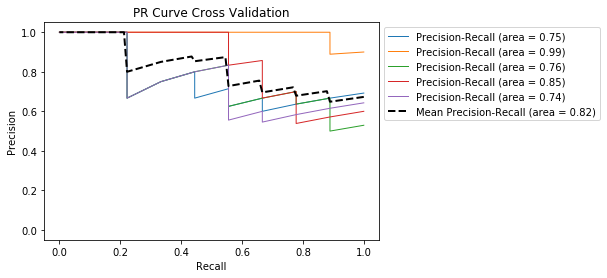

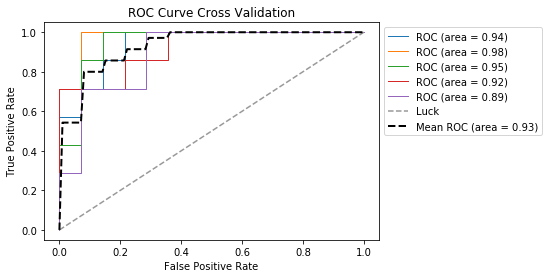

In [27]:
# plotting Cross-Validation of LogReg
lr_fig = cross_val_pr(0,x_train_gender,y_train_gender,'PR Curve Cross Validation')
lr_fig.savefig('./ml_analysis/featImp_analysis/scaled_figures/lr_selected+gender_cv_pr.pdf',bbox_inches='tight')

lr_fig = cross_val_roc(0,x_train_gender,y_train_gender,'ROC Curve Cross Validation')
lr_fig.savefig('./ml_analysis/featImp_analysis/scaled_figures/lr_selected+gender_cv_roc.pdf',bbox_inches='tight')

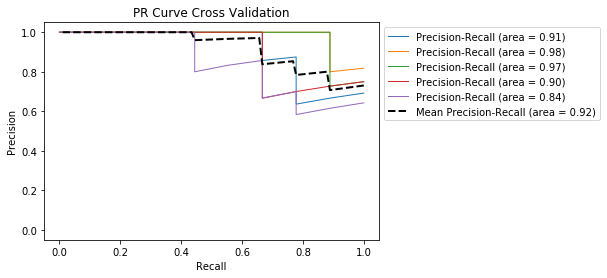

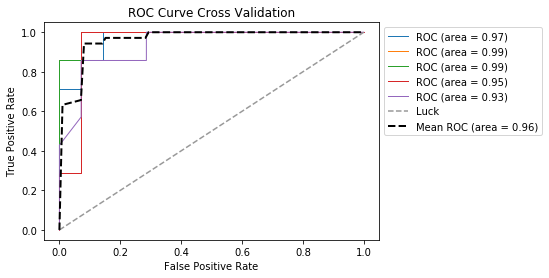

In [28]:
# Plotting CV for RF
rf_fig = cross_val_pr(1,x_train_gender,y_train_gender,'PR Curve Cross Validation')
rf_fig.savefig('./ml_analysis/featImp_analysis/scaled_figures/rf_selected+gender_cv_pr.pdf',bbox_inches='tight')

rf_fig = cross_val_roc(1,x_train_gender,y_train_gender,'ROC Curve Cross Validation')
rf_fig.savefig('./ml_analysis/featImp_analysis/scaled_figures/rf_selected+gender_cv_roc.pdf',bbox_inches='tight')

In [29]:
# training Log Reg on training data
gender_lr = LogisticRegression(random_state=0,max_iter=200)
gender_lr.fit(x_train_gender, y_train_gender)

LogisticRegression(max_iter=200, random_state=0)

In [30]:
# training RF on training data
gender_rf = RandomForestClassifier(500, oob_score=True, random_state=0)
gender_rf.fit(x_train_gender, y_train_gender)
gender_rf.oob_score_

0.8714285714285714

## 1b. Testing models on G3R

In [31]:
# get all the samples that are G3R
samples_test = [idx for idx in meta[meta.ATTRIBUTE_groups=='G3R'].index if idx in serum_tablepd.index]
exp_test = meta.loc[samples_test][['ATTRIBUTE_groups','ATTRIBUTE_adv_fibrosis']]
exp_test.rename(columns={'ATTRIBUTE_groups':'groups','ATTRIBUTE_adv_fibrosis':'adv_fibrosis'},inplace=True)
# have to drop Missing: Not collected values
exp_test = exp_test[exp_test.adv_fibrosis != 'Missing: Not collected']
print(exp_test.adv_fibrosis.value_counts())

0    21
1     7
Name: adv_fibrosis, dtype: int64


In [32]:
# Preparing the test data for Serum+gender
x_test_gender = serum_gender_table.loc[exp_test.index]
y_test_gender = []
for idx in exp_test.index:
    if exp_test.loc[idx,'adv_fibrosis'] == '1':
        y_test_gender.append(1)
    elif exp_test.loc[idx,'adv_fibrosis'] == '0':
        y_test_gender.append(0)
y_test_gender = np.array(y_test_gender)
print(len(x_test_gender))
print(len(y_test_gender))

28
28


In [33]:
#plotting Precision Recall curve 
#(code used from calour.plot_roc http://biocore.github.io/calour/generated/calour.training.plot_roc.html)
def plot_result_pr(result,title,cv=True):
    from sklearn import metrics
    from matplotlib import pyplot as plt
    import itertools
    
    cmap = plt.cm.Dark2
    fig, ax = plt.subplots()
    ax.set_aspect('equal')
    #ax.plot([0, 1], [0, 1], linestyle='-', lw=1, color='black', label='Luck', alpha=.5)

    classes = np.unique(result['Y_TRUE'].values)
    classes.sort()

    col = dict(zip(classes, itertools.cycle(cmap.colors)))

    mean_recall = np.linspace(1, 0, 100)
    for cls in classes:
        precisions = []
        aucs = []
        if cv is True:
            for grp, df in result.groupby('CV'):
                y_true = df['Y_TRUE'].values == cls
                precision, recall, thresholds = metrics.precision_recall_curve(y_true.astype(int), result[cls])
                rev_recall = recall[::-1]
                rev_precision = precision[::-1]
                mean_precision = np.interp(mean_recall, rev_recall, rev_precision)
                precisions.append(mean_precision)
                precisions[-1][0] = 0.0
                pr_auc = metrics.auc(mean_recall, mean_precision)
                aucs.append(pr_auc)

            mean_precision = np.mean(precisions, axis=0)
            #mean_tpr[-1] = 1.0
            mean_auc = np.mean(aucs)
            std_auc = np.std(aucs)
            ax.plot(mean_recall, mean_precision, color=col[cls],
                    label='{0} ({1:.2f} $\\pm$ {2:.2f})'.format(cls, mean_auc, std_auc),
                    lw=2, alpha=.8)

            std_precision = np.std(precisions, axis=0)
            precisions_upper = np.minimum(mean_precision + std_precision, 1)
            precisions_lower = np.maximum(mean_precision - std_precision, 0)
            ax.fill_between(mean_recall, precisions_lower, precisions_upper, color=col[cls], alpha=.5)
        else:
            y_true = result['Y_TRUE'].values == cls
            precision, recall, thresholds = metrics.precision_recall_curve(y_true.astype(int), result[cls])
            pr_auc = auc(recall, precision)
            # prepend zero because, if not, the curve may start in the middle of the plot.
            ax.plot(np.insert(recall, 0, 0), np.insert(precision, 0, 0), label='{0} ({1:.2f})'.format(cls, pr_auc), lw=2)

    ax.set_xlim(-0.05, 1.05)
    ax.set_ylim(-0.05, 1.05)
    ax.set_xlabel('Recall')
    ax.set_ylabel('Precision')
    ax.set_title(title)
    ax.legend(loc="lower right")

    #return ax, mean_auc if cv else pr_auc
    return plt

In [34]:
#plotting ROC curve 
#(code used from calour.plot_roc http://biocore.github.io/calour/generated/calour.training.plot_roc.html)
def plot_result_roc(result,title,cv=True):    
    from sklearn import metrics
    from matplotlib import pyplot as plt
    import itertools
    
    cmap = plt.cm.Dark2
    fig, ax = plt.subplots()
    ax.set_aspect('equal')
    ax.plot([0, 1], [0, 1], linestyle='-', lw=1, color='black', label='Luck', alpha=.5)

    classes = np.unique(result['Y_TRUE'].values)
    classes.sort()

    col = dict(zip(classes, itertools.cycle(cmap.colors)))

    mean_fpr = np.linspace(0, 1, 100)
    for cls in classes:
        tprs = []
        aucs = []
        if cv is True:
            for grp, df in result.groupby('CV'):
                y_true = df['Y_TRUE'].values == cls
                fpr, tpr, thresholds = metrics.roc_curve(y_true.astype(int), df[cls])
                mean_tpr = np.interp(mean_fpr, fpr, tpr)
                tprs.append(mean_tpr)
                tprs[-1][0] = 0.0
                roc_auc = metrics.auc(mean_fpr, mean_tpr)
                aucs.append(roc_auc)

            mean_tpr = np.mean(tprs, axis=0)
            mean_tpr[-1] = 1.0
            mean_auc = np.mean(aucs)
            std_auc = np.std(aucs)
            ax.plot(mean_fpr, mean_tpr, color=col[cls],
                    label='{0} ({1:.2f} $\\pm$ {2:.2f})'.format(cls, mean_auc, std_auc),
                    lw=2, alpha=.8)

            std_tpr = np.std(tprs, axis=0)
            tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
            tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
            ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color=col[cls], alpha=.5)
        else:
            y_true = result['Y_TRUE'].values == cls
            fpr, tpr, thresholds = roc_curve(y_true.astype(int), result[cls])
            roc_auc = auc(fpr, tpr)
            # prepend zero because, if not, the curve may start in the middle of the plot.
            ax.plot(np.insert(fpr, 0, 0), np.insert(tpr, 0, 0), label='{0} ({1:.2f})'.format(cls, roc_auc), lw=2)

    ax.set_xlim(-0.05, 1.05)
    ax.set_ylim(-0.05, 1.05)
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title(title)
    ax.legend(loc="lower right")

    #return ax, mean_auc if cv else roc_auc
    return plt

In [36]:
# testing the logistic regression gender model
result_gender_lr = pd.DataFrame(gender_lr.predict_proba(x_test_gender))
result_gender_lr.columns = gender_lr.classes_
result_gender_lr['Y_TRUE'] = y_test_gender
result_gender_lr['CV'] = 0

Average precision-recall score: 0.28


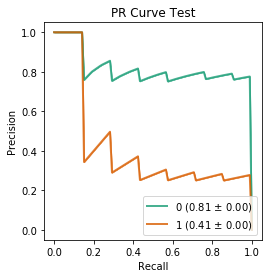

In [37]:
fig_gender_lr = plot_result_pr(result_gender_lr,'PR Curve Test')
fig_gender_lr.savefig('./ml_analysis/featImp_analysis/scaled_figures/lr_selected+gender_test_pr.pdf',bbox_inches='tight')

average_precision = metrics.average_precision_score(y_test_gender, gender_lr.predict(x_test_gender))

print('Average precision-recall score: {0:0.2f}'.format(
      average_precision))

Accuracy score: 0.43


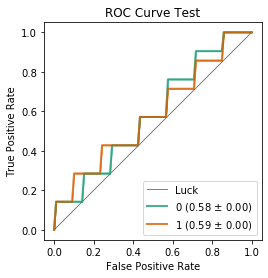

In [38]:
fig_gender_lr = plot_result_roc(result_gender_lr,'ROC Curve Test')
fig_gender_lr.savefig('./ml_analysis/featImp_analysis/scaled_figures/lr_selected+gender_test_roc.pdf',bbox_inches='tight')

acc_score = metrics.accuracy_score(y_test_gender, gender_lr.predict(x_test_gender))

print('Accuracy score: {0:0.2f}'.format(
      acc_score))

In [39]:
#testing the random forest base model
result_gender_rf = pd.DataFrame(gender_rf.predict_proba(x_test_gender))
result_gender_rf.columns = gender_rf.classes_
result_gender_rf['Y_TRUE'] = y_test_gender
result_gender_rf['CV'] = 0

Average precision-recall score: 0.23


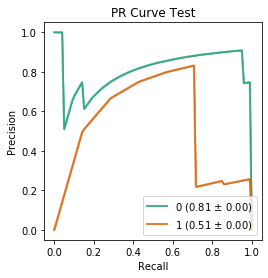

In [40]:
fig_gender_rf = plot_result_pr(result_gender_rf,'PR Curve Test')
fig_gender_rf.savefig('./ml_analysis/featImp_analysis/scaled_figures/rf_selected+gender_test_pr.pdf',bbox_inches='tight')

average_precision = metrics.average_precision_score(y_test_gender, gender_rf.predict(x_test_gender))

print('Average precision-recall score: {0:0.2f}'.format(
      average_precision))

Accuracy score: 0.25


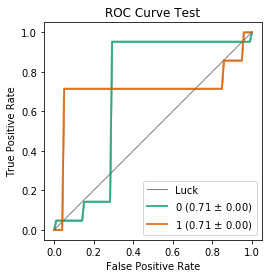

In [41]:
fig_gender_rf = plot_result_roc(result_gender_rf,'ROC Curve Test')
fig_gender_rf.savefig('./ml_analysis/featImp_analysis/scaled_figures/rf_selected+gender_test_roc.pdf',bbox_inches='tight')

acc_score = metrics.accuracy_score(y_test_gender, gender_rf.predict(x_test_gender))

print('Accuracy score: {0:0.2f}'.format(
      acc_score))

## 2. Building Serum+BMI Model

### 2a. CV/Train model on G1P+G3P

In [43]:
serum_bmi_table = serum_combined.drop(['gender','age'],axis=1)
serum_bmi_table.head(3)

,0004069a1f2c3f2b14511a4f367e485d,0013ada35a72573fde974722d6f46269,0074f0d3d22016bcdf28ee53c8a5062b,012ade16945709e69650957b8fdeb021,015bcc773d2fe77d5ddf3533aff00a9f,0171c4a4201b9604da3efc9305fc5264,017460a73612042af020d72a944567b4,01809bb355414a0015fd764cba9c5014,01a15bb425333e9bb45a57970a4fd744,01f940cc9606a206fc0f5f4be686142a,...,05f6086a8a2cee842fda8dc71868f23d,06019d17a3cd04f8295187a39b9f7cce,063213c83267364b5b0ccf512becab23,063f5f9ab89e7e225a8cc70d0820bce2,06461aee927ad826dda0a5fc6d39c846,0673b3adc860840b18a7e69687f15bdd,068d58684ec6f603e3d04c33b7e171f5,06afebce624262f62bdb4c2a797259a7,06e71388f4d2d3022774b14da2cdc5f7,bmi
sampleid,,,,,,,,,,,,,,,,,,,,,
TW-CO-002,1.057551,0.713690,0.101371,0.133053,-0.286215,-0.318617,0.065534,-0.279881,0.117167,-0.301339,...,6.690494,-0.481142,-0.429791,-0.035245,-0.092897,-0.172427,-0.784552,-0.446800,0.306839,27.9
TW-BT-001,4.324877,3.217350,-0.021519,3.134937,6.154245,-0.316190,4.300775,0.274048,0.371661,-0.301339,...,-0.048940,0.736328,0.712659,-0.418597,4.751864,-0.173422,3.218215,0.431494,5.752049,25.4
TW-CA-002,-0.503911,0.362269,-0.075956,1.604561,0.699963,-0.318680,0.459769,0.823721,0.202315,-0.280759,...,-0.156736,1.698044,-0.238973,0.535716,-0.145039,-0.166807,-0.473815,-0.529970,0.520689,36.4


In [44]:
# preparing training data
x_train_bmi = serum_bmi_table.loc[exp_train.index]
# label encoder
y_train_bmi = []
for idx in exp_train.index:
    if exp_train.loc[idx,'adv_fibrosis'] == '1':
        y_train_bmi.append(1)
    # even values that are 'missing' are still 0 for adv fibrosis
    else:
        y_train_bmi.append(0)
y_train_bmi = np.array(y_train_bmi)
#ensuring we have correct samples x features
print(x_train_bmi.shape)
print(len(y_train_bmi))

(70, 50)
70


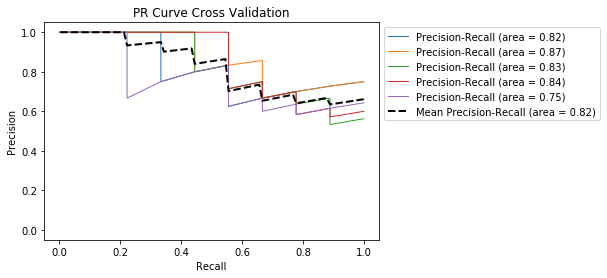

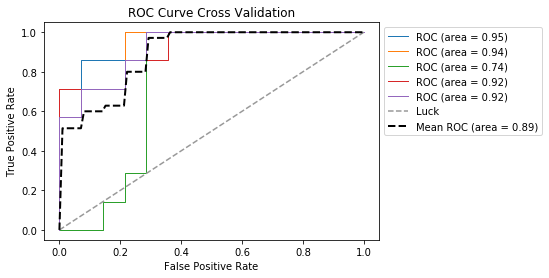

In [45]:
fig_lr = cross_val_pr(0,x_train_bmi,y_train_bmi,'PR Curve Cross Validation')
fig_lr.savefig('ml_analysis/featImp_analysis/scaled_figures/lr_selected+BMI_cv_pr.pdf',bbox_inches='tight')

fig_lr = cross_val_roc(0,x_train_bmi,y_train_bmi,'ROC Curve Cross Validation')
fig_lr.savefig('ml_analysis/featImp_analysis/scaled_figures/lr_selected+BMI_cv_roc.pdf',bbox_inches='tight')

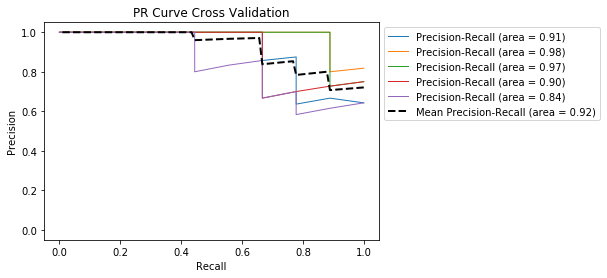

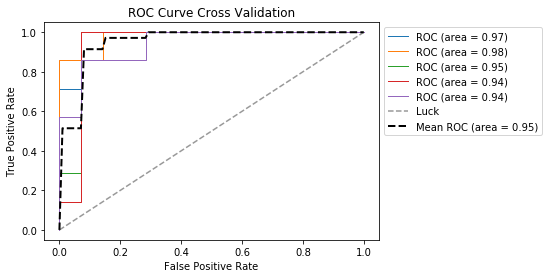

In [46]:
fig_rf = cross_val_pr(1,x_train_bmi,y_train_bmi,'PR Curve Cross Validation')
fig_rf.savefig('ml_analysis/featImp_analysis/scaled_figures/rf_selected+BMI_cv_pr.pdf',bbox_inches='tight')

fig_rf = cross_val_roc(1,x_train_bmi,y_train_bmi,'ROC Curve Cross Validation')
fig_rf.savefig('ml_analysis/featImp_analysis/scaled_figures/rf_selected+BMI_cv_roc.pdf',bbox_inches='tight')


In [47]:
#training Log Reg on training data
bmi_lr = LogisticRegression(random_state=0,max_iter=200)
bmi_lr.fit(x_train_bmi, y_train_bmi)

LogisticRegression(max_iter=200, random_state=0)

In [48]:
#training RF on training data
bmi_rf = RandomForestClassifier(500, oob_score=True, random_state=0)
bmi_rf.fit(x_train_bmi, y_train_bmi)
bmi_rf.oob_score_

0.8714285714285714

### 2b. Testing Models on G3R Samples

In [49]:
exp_test.adv_fibrosis.value_counts()

0    21
1     7
Name: adv_fibrosis, dtype: int64

In [50]:
# Preparing the test data
x_test_bmi = serum_bmi_table.loc[exp_test.index]
y_test_bmi = []
for idx in exp_test.index:
    if exp_test.loc[idx,'adv_fibrosis'] == '1':
        y_test_bmi.append(1)
    elif exp_test.loc[idx,'adv_fibrosis'] == '0':
        y_test_bmi.append(0)
y_test_bmi = np.array(y_test_bmi)
print(x_test_bmi.shape)
print(len(y_test_bmi))

(28, 50)
28


In [51]:
#testing log reg
result_bmi_lr = pd.DataFrame(bmi_lr.predict_proba(x_test_bmi))
result_bmi_lr.columns = bmi_lr.classes_
result_bmi_lr['Y_TRUE'] = y_test_bmi
result_bmi_lr['CV'] = 0

Average precision-recall score: 0.29


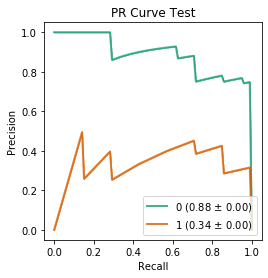

In [52]:
fig_bmi_lr = plot_result_pr(result_bmi_lr,'PR Curve Test')
fig_bmi_lr.savefig('ml_analysis/featImp_analysis/scaled_figures/lr_selected+BMI_test_pr.pdf',bbox_inches='tight')

average_precision = metrics.average_precision_score(y_test_bmi, bmi_lr.predict(x_test_bmi))

print('Average precision-recall score: {0:0.2f}'.format(
      average_precision))

Accuracy score: 0.39


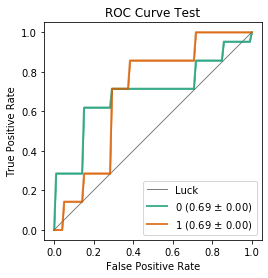

In [53]:
fig_bmi_lr = plot_result_roc(result_bmi_lr,'ROC Curve Test')
fig_bmi_lr.savefig('ml_analysis/featImp_analysis/scaled_figures/lr_selected+BMI_test_roc.pdf',bbox_inches='tight')

acc_score = metrics.accuracy_score(y_test_bmi, bmi_lr.predict(x_test_bmi))

print('Accuracy score: {0:0.2f}'.format(
      acc_score))

In [54]:
#testing the random forest selected feature model
result_bmi_rf = pd.DataFrame(bmi_rf.predict_proba(x_test_bmi))
result_bmi_rf.columns = bmi_rf.classes_
result_bmi_rf['Y_TRUE'] = y_test_bmi
result_bmi_rf['CV'] = 0

Average precision-recall score: 0.23


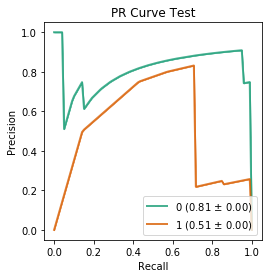

In [56]:
fig_bmi_rf = plot_result_pr(result_bmi_rf,'PR Curve Test')
fig_bmi_rf.savefig('ml_analysis/featImp_analysis/scaled_figures/rf_selected+BMI_test_pr.pdf',bbox_inches='tight')

average_precision = metrics.average_precision_score(y_test_bmi, bmi_rf.predict(x_test_bmi))

print('Average precision-recall score: {0:0.2f}'.format(
      average_precision))

Accuracy score: 0.25


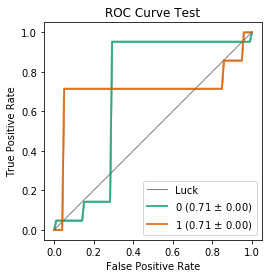

In [58]:
fig_bmi_rf = plot_result_roc(result_bmi_rf,'ROC Curve Test')
fig_bmi_rf.savefig('ml_analysis/featImp_analysis/scaled_figures/rf_selected+BMI_test_roc.pdf',bbox_inches='tight')

acc_score = metrics.accuracy_score(y_test_bmi, bmi_rf.predict(x_test_bmi))

print('Accuracy score: {0:0.2f}'.format(
      acc_score))

## 3. Building Serum+Age Model

### 3a. CV/Train Model on G1P+G3P data

In [59]:
exp_train.groups.value_counts()

G1P    48
G3P    22
Name: groups, dtype: int64

In [60]:
serum_age_table = serum_combined.drop(['gender','bmi'],axis=1)
serum_age_table.head(3)

,0004069a1f2c3f2b14511a4f367e485d,0013ada35a72573fde974722d6f46269,0074f0d3d22016bcdf28ee53c8a5062b,012ade16945709e69650957b8fdeb021,015bcc773d2fe77d5ddf3533aff00a9f,0171c4a4201b9604da3efc9305fc5264,017460a73612042af020d72a944567b4,01809bb355414a0015fd764cba9c5014,01a15bb425333e9bb45a57970a4fd744,01f940cc9606a206fc0f5f4be686142a,...,05f6086a8a2cee842fda8dc71868f23d,06019d17a3cd04f8295187a39b9f7cce,063213c83267364b5b0ccf512becab23,063f5f9ab89e7e225a8cc70d0820bce2,06461aee927ad826dda0a5fc6d39c846,0673b3adc860840b18a7e69687f15bdd,068d58684ec6f603e3d04c33b7e171f5,06afebce624262f62bdb4c2a797259a7,06e71388f4d2d3022774b14da2cdc5f7,age
sampleid,,,,,,,,,,,,,,,,,,,,,
TW-CO-002,1.057551,0.713690,0.101371,0.133053,-0.286215,-0.318617,0.065534,-0.279881,0.117167,-0.301339,...,6.690494,-0.481142,-0.429791,-0.035245,-0.092897,-0.172427,-0.784552,-0.446800,0.306839,54
TW-BT-001,4.324877,3.217350,-0.021519,3.134937,6.154245,-0.316190,4.300775,0.274048,0.371661,-0.301339,...,-0.048940,0.736328,0.712659,-0.418597,4.751864,-0.173422,3.218215,0.431494,5.752049,49
TW-CA-002,-0.503911,0.362269,-0.075956,1.604561,0.699963,-0.318680,0.459769,0.823721,0.202315,-0.280759,...,-0.156736,1.698044,-0.238973,0.535716,-0.145039,-0.166807,-0.473815,-0.529970,0.520689,61


In [62]:
# preparing training data
x_train_age = serum_age_table.loc[exp_train.index]
# label encoder
y_train_age = []
for idx in exp_train.index:
    if exp_train.loc[idx,'adv_fibrosis'] == '1':
        y_train_age.append(1)
    # even values that are 'missing' are still 0 for adv fibrosis
    else:
        y_train_age.append(0)
y_train_age = np.array(y_train_age)
# ensuring we have correct samples x features
print(x_train_age.shape)
print(len(y_train_age))

(70, 50)
70


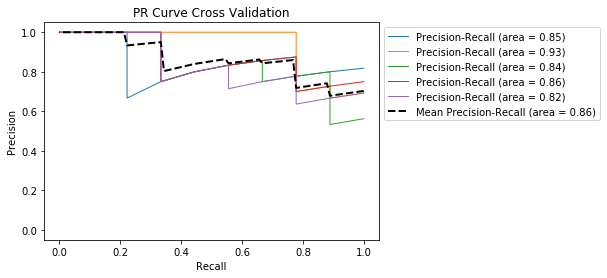

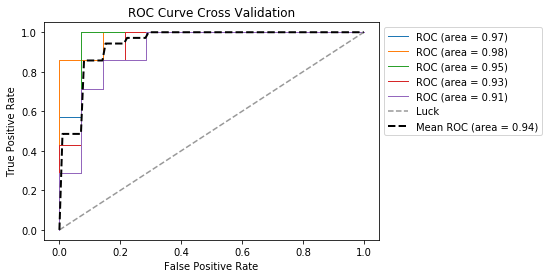

In [63]:
fig_lr = cross_val_pr(0,x_train_age,y_train_age,'PR Curve Cross Validation')
fig_lr.savefig('ml_analysis/featImp_analysis/scaled_figures/lr_selected+age_cv_pr.pdf',bbox_inches='tight')

fig_lr = cross_val_roc(0,x_train_age,y_train_age,'ROC Curve Cross Validation')
fig_lr.savefig('ml_analysis/featImp_analysis/scaled_figures/lr_selected+age_cv_roc.pdf',bbox_inches='tight')


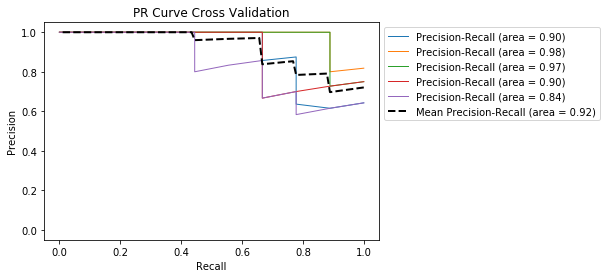

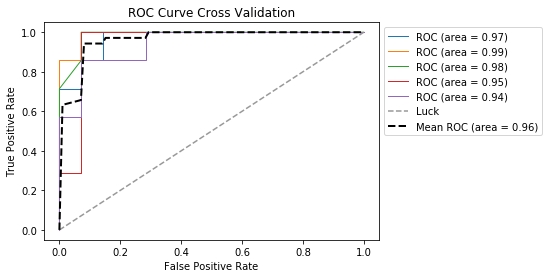

In [64]:
fig_rf = cross_val_pr(1,x_train_age,y_train_age,'PR Curve Cross Validation')
fig_rf.savefig('ml_analysis/featImp_analysis/scaled_figures/rf_selected+age_cv_pr.pdf',bbox_inches='tight')

fig_rf = cross_val_roc(1,x_train_age,y_train_age,'ROC Curve Cross Validation')
fig_rf.savefig('ml_analysis/featImp_analysis/scaled_figures/rf_selected+age_cv_roc.pdf',bbox_inches='tight')


In [65]:
#training Log Reg on training data
age_lr = LogisticRegression(random_state=0,max_iter=200)
age_lr.fit(x_train_age, y_train_age)

LogisticRegression(max_iter=200, random_state=0)

In [66]:
#training RF on training data
age_rf = RandomForestClassifier(500, oob_score=True, random_state=0)
age_rf.fit(x_train_age, y_train_age)
age_rf.oob_score_

0.8714285714285714

### 3b. Testing Models on G3R data

In [67]:
exp_test.adv_fibrosis.value_counts()

0    21
1     7
Name: adv_fibrosis, dtype: int64

In [68]:
# Preparing the test data
x_test_age = serum_age_table.loc[exp_test.index]
y_test_age = []
for idx in exp_test.index:
    if exp_test.loc[idx,'adv_fibrosis'] == '1':
        y_test_age.append(1)
    elif exp_test.loc[idx,'adv_fibrosis'] == '0':
        y_test_age.append(0)
y_test_age = np.array(y_test_age)
print(x_test_age.shape)
print(len(y_test_age))

(28, 50)
28


In [69]:
# testing log reg
result_age_lr = pd.DataFrame(age_lr.predict_proba(x_test_age))
result_age_lr.columns = age_lr.classes_
result_age_lr['Y_TRUE'] = y_test_age
result_age_lr['CV'] = 0

Average precision-recall score: 0.29


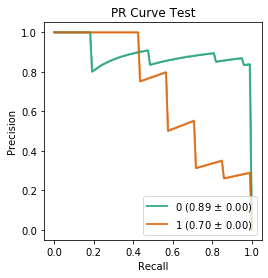

In [71]:
# showing Precision-recall results
fig_age_lr = plot_result_pr(result_age_lr,'PR Curve Test')
fig_age_lr.savefig('ml_analysis/featImp_analysis/scaled_figures/lr_selected+age_test_pr.pdf',bbox_inches='tight')

average_precision = metrics.average_precision_score(y_test_age, age_lr.predict(x_test_age))

print('Average precision-recall score: {0:0.2f}'.format(
      average_precision))

Accuracy score: 0.54


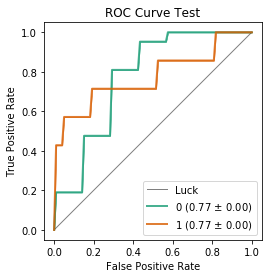

In [72]:
#showing accuracy/ROC results
fig_age_lr = plot_result_roc(result_age_lr,'ROC Curve Test')
fig_age_lr.savefig('ml_analysis/featImp_analysis/scaled_figures/lr_selected+age_test_roc.pdf',bbox_inches='tight')

acc_score = metrics.accuracy_score(y_test_age, age_lr.predict(x_test_age))

print('Accuracy score: {0:0.2f}'.format(
      acc_score))

In [73]:
# testing random forest
result_age_rf = pd.DataFrame(age_rf.predict_proba(x_test_age))
result_age_rf.columns = age_rf.classes_
result_age_rf['Y_TRUE'] = y_test_age
result_age_rf['CV'] = 0

Average precision-recall score: 0.23


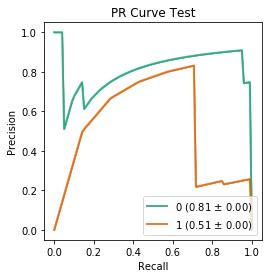

In [74]:
# showing Precision-recall results
fig_age_rf = plot_result_pr(result_age_rf,'PR Curve Test')
fig_age_rf.savefig('ml_analysis/featImp_analysis/scaled_figures/rf_selected+age_test_pr.pdf',bbox_inches='tight')

average_precision = metrics.average_precision_score(y_test_age, age_rf.predict(x_test_age))

print('Average precision-recall score: {0:0.2f}'.format(
      average_precision))

Accuracy score: 0.25


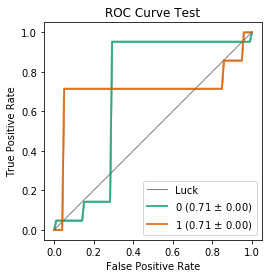

In [75]:
#showing accuracy/ROC results
fig_age_rf = plot_result_roc(result_age_rf,'ROC Curve Test')
fig_age_rf.savefig('ml_analysis/featImp_analysis/scaled_figures/rf_selected+age_test_roc.pdf',bbox_inches='tight')

acc_score = metrics.accuracy_score(y_test_age, age_rf.predict(x_test_age))

print('Accuracy score: {0:0.2f}'.format(
      acc_score))